# Podstawowe algorytmy kwantowe w Qiskit

In [1]:
from typing import Callable, Iterable, NewType, Tuple
import qiskit as qs
from qiskit.circuit import Gate
from qiskit.circuit.library import MCMTGate, ZGate
import numpy as np
from qiskit_aer import AerSimulator
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

def plot_counts(counts: dict, ax: Axes):
    ax.bar(list(counts.keys()), list(counts.values()))

backend = AerSimulator()

## Wstęp
### Kubit
- Sfera Blocha

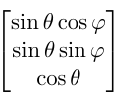
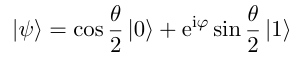
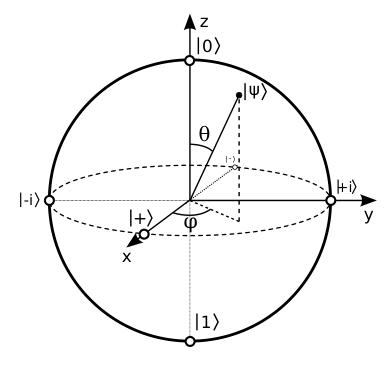

- Notacja Diraca/bra-ket
- ket

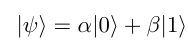
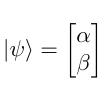
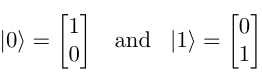

- bra 


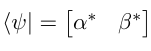
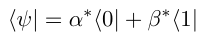
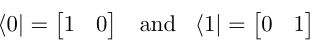

- operator Hermitowski †


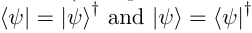

- iloczyn skalarny (wewnętrzny)

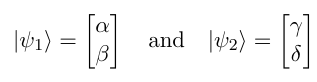
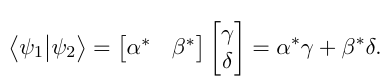

## Pomiar
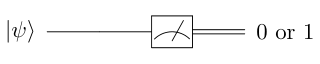
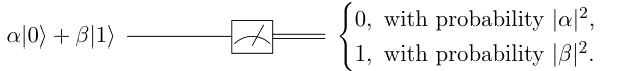

## Podstawowe bramki 1-kubitowe
- Bramka Hadamarda

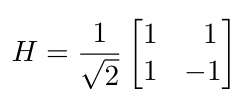
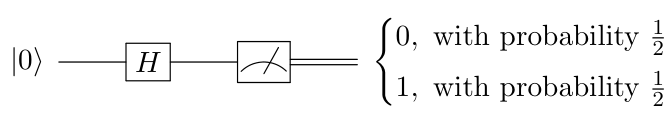


H |1⟩ = |-⟩, H |0⟩ = |+⟩

- Bramka X (kwantowe NOT)


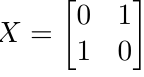
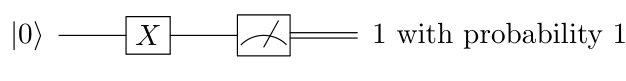
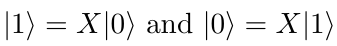


- Bramka Z


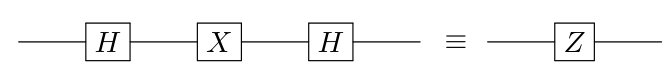


## Stany kwantowe
- Układ 2-kubitowy


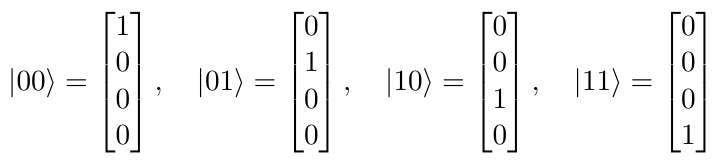 
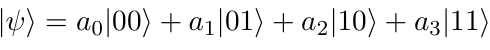
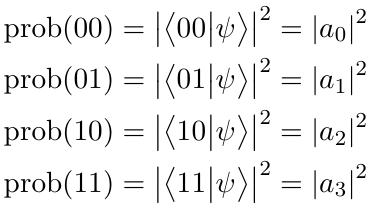

- Iloczyn Kroneckera ⊗


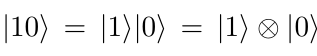
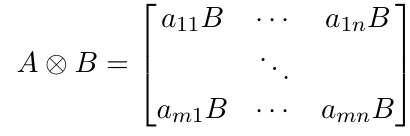
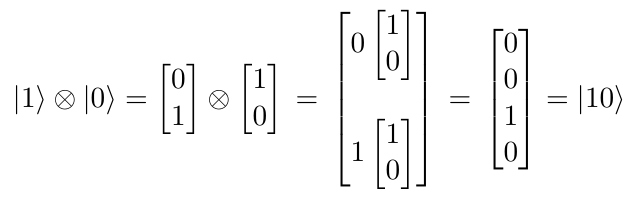
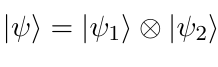

- Spltątanie
    - Zawsze można uzyskać stan układu złożonego znając stany jego części, ale odwrotny proces niekoniecznie jest możliwy.
    - Układ, którego nie można sfaktoryzować pod względem iloczynu Kroneckera jest **splątany**.

- Stan czysty 
    - 100% pewności, że układ opisany jest przez pewien wektor.

- Stan mieszany
    - Układ opisany jest przez pewien wektor z pewnym prawdopodobieństwem, lub przez inny wektor z innym prawdopodobieństwem.

- Macierz gęstości (ensemble)
    - Opisuje prawdopodobieństwa każdego z możliwych stanów czystych.

## Podstawowe bramki 2-kubitowe i wielokubitowe
- Kontrolowana bramka NOT (CNOT)


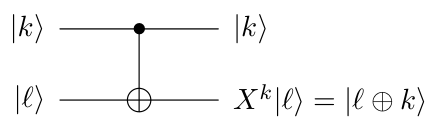

- Kontrolowana bramka Z (CZ)


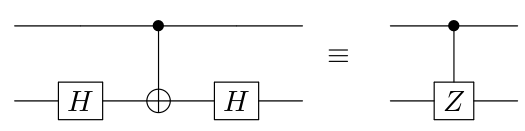

- Bramka Toffoliego (CCNOT)


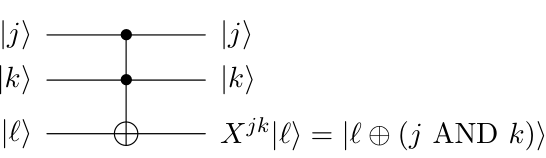

- Zanegowana bramka Toffoliego


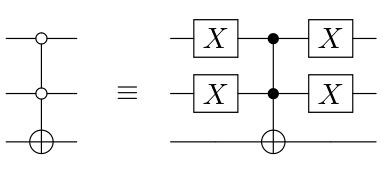



## Algorytmy
- Deutch'a-Jozs'y
- Grover'a
- Shor'a faktoryzacji
- problem Simona


## Algorytm Deutsch'a-Jozs'y
### Problem
Dana jest funkcja $f:\{0, 1\}^n \rightarrow \{0, 1\}$. Funkcja może być:
 - Stała: dla każdego $\{0, 1\}^n$ zwraca $0$ lub $1$ 
 - Zbalansowana: dla połowy $\{0, 1\}^n$ zwraca $0$, dla drugiej $1$


Algorytm Deutsch'a-Jozs'y odpowiada na pytanie czy $f$ jest stała, czy zbalansowana.

### Podejście klasyczne
- Najlepszy przypadek: pierwsze dwa zawołania $f$ zwracają różne wartości $\rightarrow$ $f$ jest zbalansowana
- Najgorszy przypadek: pierwsze $2^{n-1}$ zawołań $f$ zwraca tą samą wartość, dopiero przy $2^{n-1}+1$ zawołaniu zwracana jest
     - ta sama wartość co wcześniej $\rightarrow$ $f$ jest stała
     - inna wartość niż wcześniej $\rightarrow$ $f$ jest zbalansowana

In [2]:

OracleType = NewType('OracleType', int)
ORACLE_CONST_0 = OracleType(0)
ORACLE_CONST_1 = OracleType(1)
ORACLE_BALANCED = OracleType(2)

n = 3

In [3]:
def dj_oracle_generate(oracle_type: OracleType, n: int) -> Tuple[qs.QuantumCircuit, Gate]:
    oracle = qs.QuantumCircuit(n+1)

    if oracle_type == ORACLE_CONST_0:
        pass

    elif oracle_type == ORACLE_CONST_1:
        oracle.x(range(n))

    elif oracle_type == ORACLE_BALANCED:
        def add_cx(state : int) -> None:
            for qubit, cbit in enumerate(reversed(f"{state:0b}")):
                if cbit == '1':
                    oracle.x(qubit)
        
        one_states = np.random.choice(range(2**n), size=2**(n-1), replace=False)
        for state in one_states:
            add_cx(state)
            oracle.mcx(list(range(n)), n)
            add_cx(state)

    oracle_gate = oracle.to_gate()
    oracle_gate.name = f"Oracle"

    return oracle, oracle_gate

### Wyrocznia zbalansowana

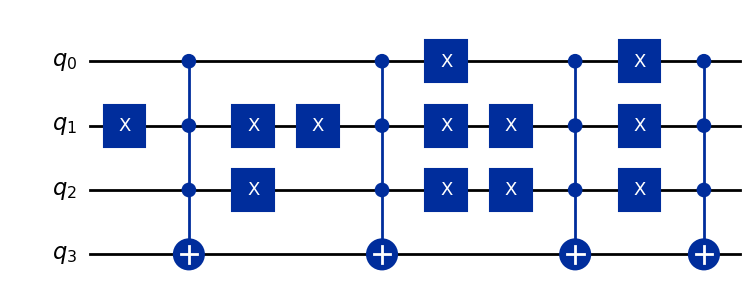

In [4]:
dj_oracle_balanced, dj_oracle_balanced_gate = dj_oracle_generate(ORACLE_BALANCED, n)
dj_oracle_balanced.draw('mpl')

### Wyrocznia stała

#### Stała 0

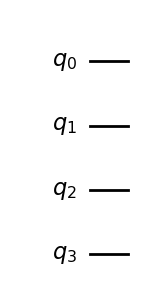

In [5]:
dj_oracle_const_0, dj_oracle_const_0_gate = dj_oracle_generate(ORACLE_CONST_0, n)
dj_oracle_const_0.draw('mpl')

#### Stała 1

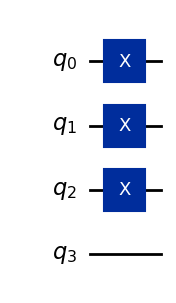

In [6]:
dj_oracle_const_1, dj_oracle_const_1_gate = dj_oracle_generate(ORACLE_CONST_1, n)
dj_oracle_const_1.draw('mpl')

### Algorytm
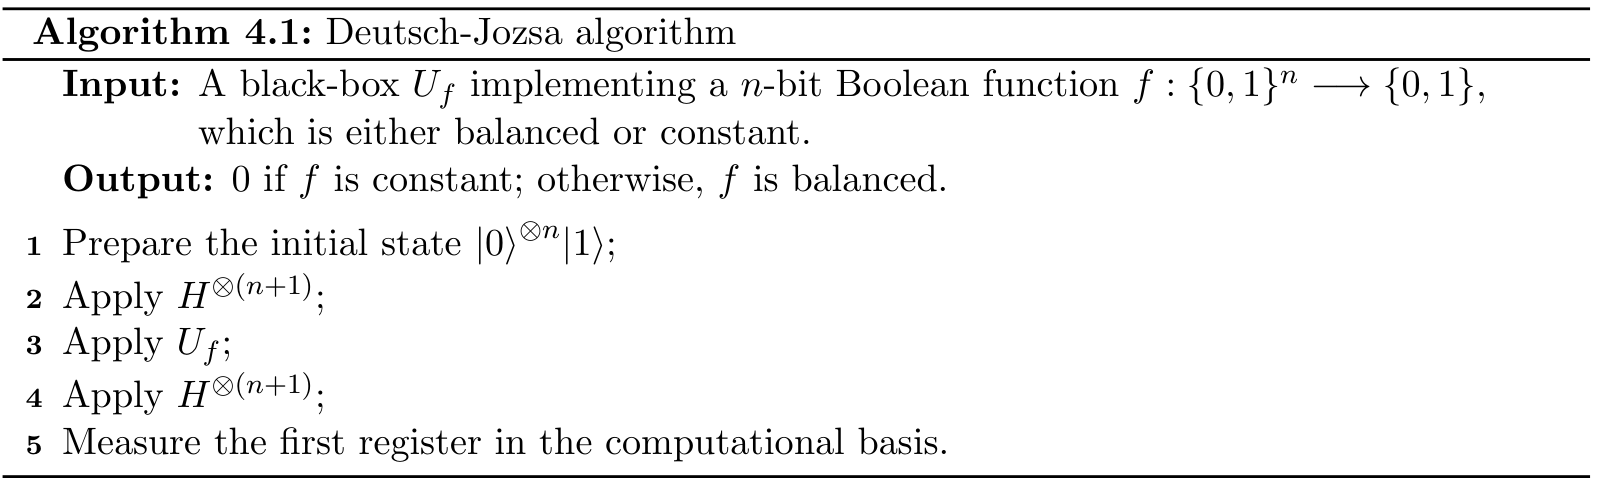

#### Zasada działania
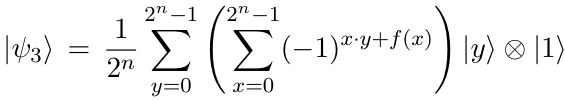
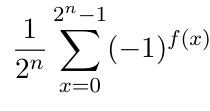

- Wyrocznia stała

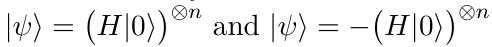
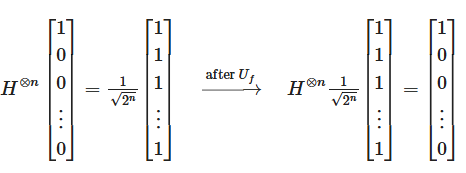

- Wyrocznia zbalansowana


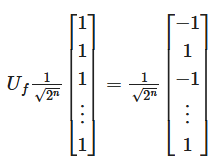

In [7]:
def dj_algorithm_circuit_generate(oracle: Gate | qs.QuantumCircuit, n: int) -> qs.QuantumCircuit:
    dj_circuit = qs.QuantumCircuit(n+1, n)
    dj_circuit.x(n)
    dj_circuit.h(range(n+1))
    dj_circuit.append(oracle, range(n+1))
    dj_circuit.h(range(n))
    dj_circuit.measure(range(n), range(n))

    return dj_circuit

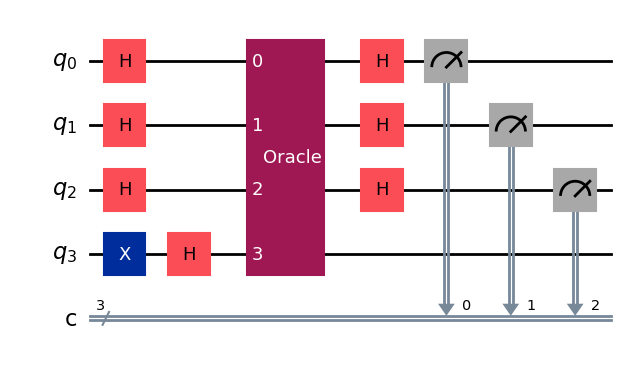

In [8]:
dj_circuit_balanced = dj_algorithm_circuit_generate(dj_oracle_balanced_gate, n)
dj_circuit_balanced.draw('mpl')

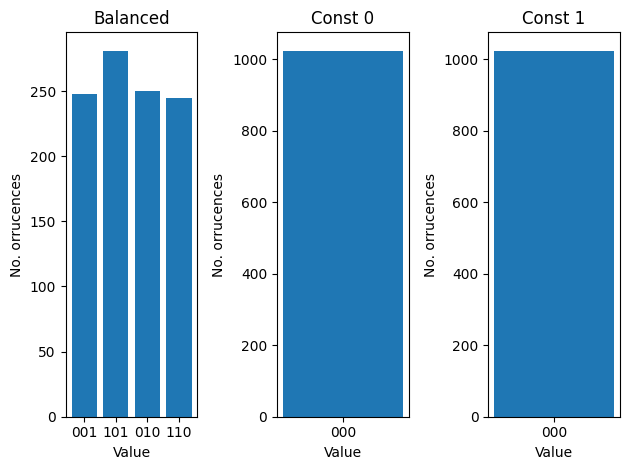

In [9]:
dj_circuit_balanced_transpiled = qs.transpile(dj_circuit_balanced, backend)
dj_circuit_const_0_transpiled = qs.transpile(dj_algorithm_circuit_generate(dj_oracle_const_0_gate, n), backend)
dj_circuit_const_1_transpiled = qs.transpile(dj_algorithm_circuit_generate(dj_oracle_const_1_gate, n), backend)
counts_balanced = backend.run(dj_circuit_balanced_transpiled, shots=1024).result().get_counts()
counts_const_0 = backend.run(dj_circuit_const_0_transpiled, shots=1024).result().get_counts()
counts_const_1 = backend.run(dj_circuit_const_1_transpiled, shots=1024).result().get_counts()


fig, ax = plt.subplots(1, 3)
ax[0].set_title('Balanced')
ax[1].set_title('Const 0')
ax[2].set_title('Const 1')

ax[0].set_ylabel('No. orrucences')
ax[1].set_ylabel('No. orrucences')
ax[2].set_ylabel('No. orrucences')

ax[0].set_xlabel('Value')
ax[1].set_xlabel('Value')
ax[2].set_xlabel('Value')


plot_counts(counts_balanced, ax[0])
plot_counts(counts_const_0, ax[1])
plot_counts(counts_const_1, ax[2])

fig.tight_layout()


## Algorytm Grover'a
### Problem
Dana jest funkcja $f$, gdzie 
- $N = 2^n$
- $f:\{0,\ldots,N-1\} \rightarrow \{0, 1\}$
- $f(x)=1 \iff x = x_0$, czyli $f(x)=1$ jeśli $x=x_0$, w innych przypadkach $f(x)=0$
- $x_0$ może być wiele

Algorytm Grover'a znajduje $x_0$.

### Podejście klasyczne
- Najlepszy przypadek: pierwsze zawołanie $f$ zwraca $1$


- Najgorszy przypadek: $N$-te zawołanie $f$ zwraca $1$ 


In [10]:
n = 3

### Wyrocznia Grovera

In [11]:
def grover_oracle_generate(n : int, marked_states: list) -> Tuple[qs.QuantumCircuit, Gate]:
    oracle = qs.QuantumCircuit(n)

    for state in marked_states:
        state_str = f"{state:0{n}b}"[::-1]
        if len(state_str) > n:
            raise ValueError()
        
        zeros = [zero for zero, val in enumerate(state_str) if val == '0']
        oracle.x(zeros)
        oracle.append(MCMTGate(ZGate(), n - 1, 1), range(n))
        oracle.x(zeros)
    
    oracle_gate = oracle.to_gate()
    oracle_gate.name = 'Oracle'

    return oracle, oracle_gate

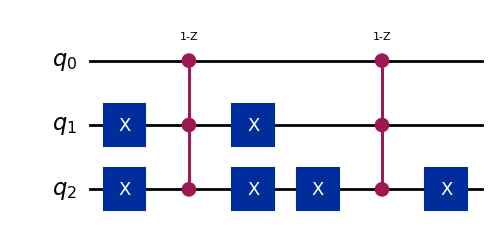

In [12]:
marked_states = [1, 3]
grover_oracle, grover_oracle_gate = grover_oracle_generate(n, marked_states)

grover_oracle.draw('mpl')

### Algorytm
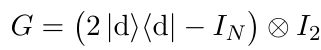
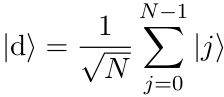
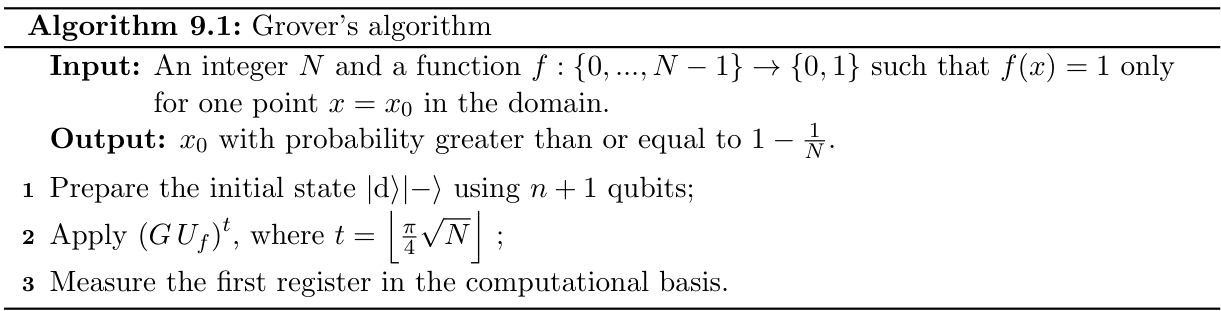

#### Zasada działania
1. 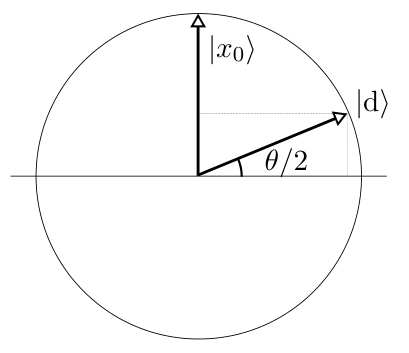
2. 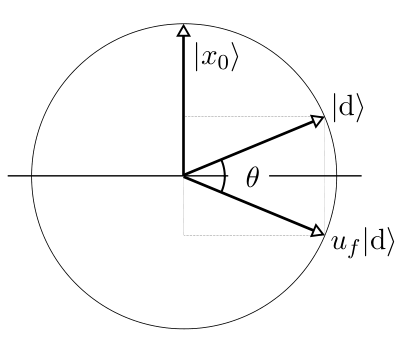
3. 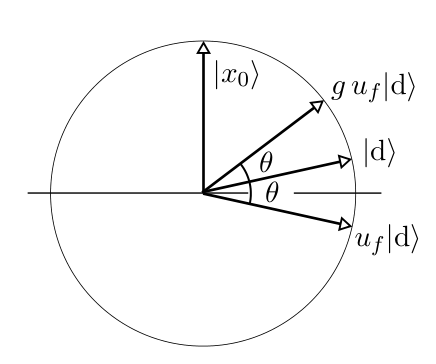
4. 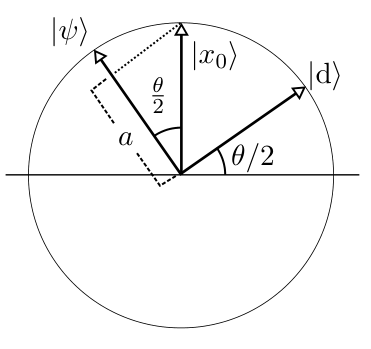

### Podstawa Grovera
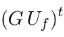

In [13]:
def grover_base_generate(oracle: Gate, n : int) ->  Tuple[qs.QuantumCircuit, Gate]:
    grover_op_circuit = qs.QuantumCircuit(n)
    grover_op_circuit.append(oracle, range(n))
    
    # Grover diffusion operator
    grover_op_circuit.h(range(n))
    grover_op_circuit.x(range(n))
    grover_op_circuit.append(MCMTGate(ZGate(), n - 1, 1), range(n))
    grover_op_circuit.x(range(n))
    grover_op_circuit.h(range(n))
    
    grover_op_gate = grover_op_circuit.to_gate()
    grover_op_gate.name = 'Grover'

    return grover_op_circuit, grover_op_gate

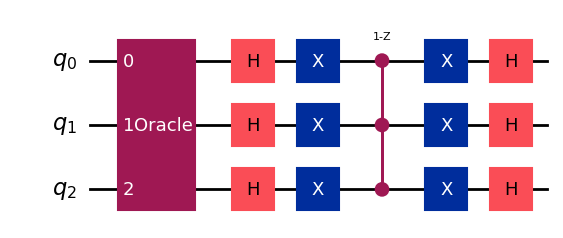

In [14]:
grover_op_circuit, _ = grover_base_generate(grover_oracle_gate, n)
grover_op_circuit.draw('mpl')

In [15]:
def grover_algorithm_circuit_generate(oracle: Gate, n : int, num_states : int) -> Tuple[qs.QuantumCircuit, int]:
    grover_circuit = qs.QuantumCircuit(n, n)
    grover_circuit.h(range(n))

    grover_op_circuit, grover_op_gate = grover_base_generate(oracle, n)
    
    iterations = int(np.pi / 4 * np.sqrt(2**n / num_states))
    grover_circuit.append(grover_op_gate.power(iterations), range(n))

    grover_circuit.measure(range(n), range(n))
    
    return grover_circuit, iterations


Iterations: 1


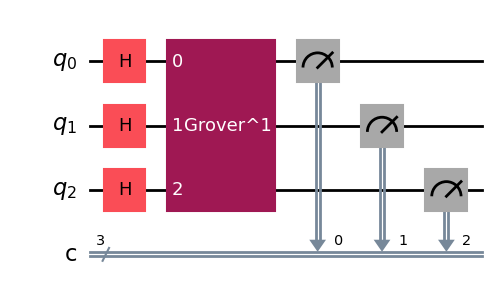

In [16]:
grover_algorithm_circuit, iterations = grover_algorithm_circuit_generate(grover_oracle_gate, n, len(marked_states))
print(f"Iterations: {iterations}")
grover_algorithm_circuit.draw("mpl")

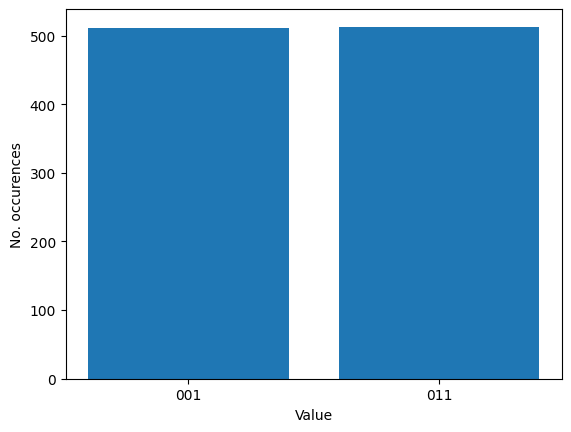

In [17]:
grover_circuit_transpiled = qs.transpile(grover_algorithm_circuit, backend)
counts_grover = backend.run(grover_circuit_transpiled, shots=1024).result().get_counts()

fig, ax = plt.subplots(1)

ax.set_ylabel('No. occurences')
ax.set_xlabel('Value')

plot_counts(counts_grover, ax)

# Algorytm faktoryzacji liczb całkowitych Shor'a

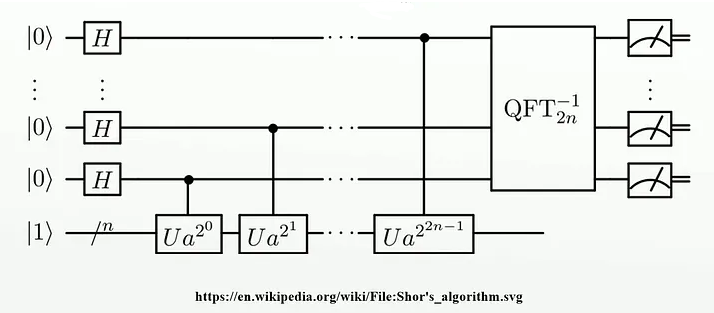

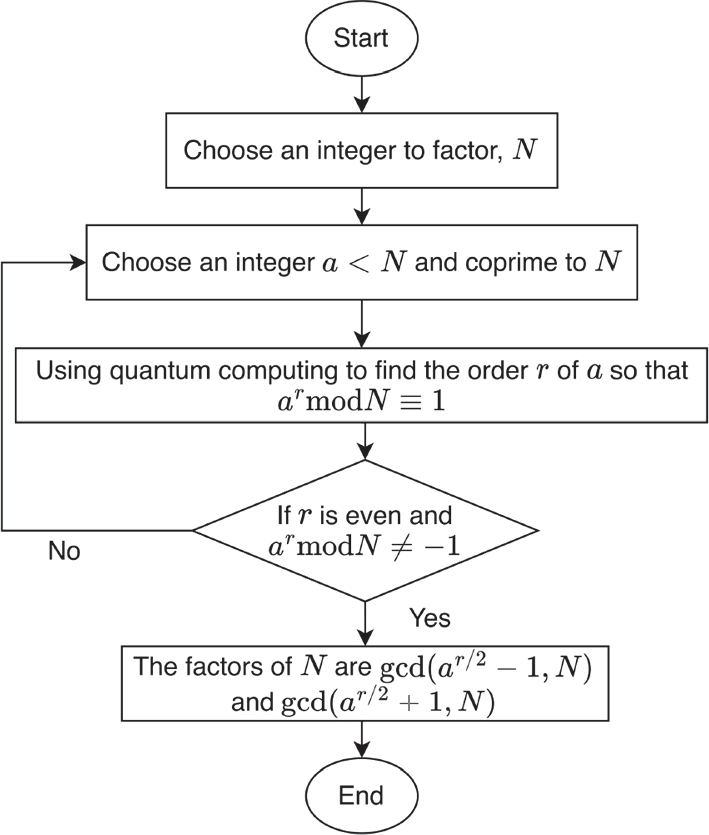


Celem algorytmu, dla liczby N składającej się z iloczynu dwóch liczb pierwszych jest odkrycie ich wartości

<!-- wybierz a 

jeśli gcd(a, N) > 1

określamy jeśli równe 1

używamy quantum computing szykamy min r takiego że a^r = 1 mod N jeśli r jest nieparzyste albo a^(r/2) = -1 mod N
    Tworzymy rejestr sterujący i rejestr roboczy

    nakładając bramki Hadamarda tworzymy superpozycję wszystkich możliwych rozwiązań
    
    Splatamy rejest roboczy i sterujący

    ponieważ mod N jest okresowe, możemy wykorzystać operacje kwantowe 

    dostosowujemy ułamki łańcuchowe żeby znaleźć r_min


losujemy nowe a obliczamy gcd dla gcd(a^(r/2)-1, N) i gcd(a^(r/2)+1, N) i rekurencyjnie sprawdzam czy one są szukanymi punktami -->

In [18]:
import numpy as np
from math import gcd
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from fractions import Fraction
import random


def mod_exp(a, x, N):
    return pow(a, x, N)

def period_finding_circuit(a, N):
    n = N.bit_length()
    t = 2 * n 

    qc = QuantumCircuit(t + n, t)

    qc.h(range(t))

    qc.x(t)

    for i in range(t):
        exponent = 2 ** i
        U = QuantumCircuit(n)
        for _ in range(exponent):
            U = U.compose(QuantumCircuit(n).unitary(
                np.eye(2**n), range(n)
            ))
        qc.append(U.to_gate().control(), [i] + list(range(t, t+n)))

    qc.append(QFT(t, inverse=True), range(t))
    qc.measure(range(t), range(t))

    return qc

def find_period(a, N):
    n = N.bit_length()
    t = 2 * n

    qc = QuantumCircuit(t, t)

    qc.h(range(t))

    r = None
    for k in range(1, N):
        if pow(a, k, N) == 1:
            r = k
            break

    if r is None:
        return None

    phase = random.randint(0, 2**t - 1)
    frac = Fraction(phase, 2**t).limit_denominator(N)

    return r



def shor(N):
    if N % 2 == 0:
        return 2, N // 2

    while True:
        a = random.randrange(2, N)
        g = gcd(a, N)

        if g != 1:
            return g, N // g

        r = find_period(a, N)
        if r is None or r % 2 != 0:
            continue

        x = pow(a, r // 2, N)
        if x == 1 or x == N - 1:
            continue

        p = gcd(x - 1, N)
        q = gcd(x + 1, N)

        if p * q == N:
            return p, q


In [19]:
N = 40489847 #1007261
#5113, 197, 7919
factors = shor(N)
print(f"Rozkład {N} = {factors[0]} × {factors[1]}")

Rozkład 40489847 = 7919 × 5113


# Algorytm problemu Simona

f(x) = f(y) ⟺ x ⊕ y = s

dla każdego x i y zapisanego binarnie, operacja XOR na bitach zawsze zwróci tą samą liczbę 

<!-- wykonujemy Hadamardy tworzymy hiperpozycję wszystkich możliwych stanów binarnych x

Używając oracle łączymy ze sobą qbitowe reprezentacje x i f(x)

ustawiamy wartości na f(x) zależne od x

wykonujemy Hadamardy na x, aby wywołać interferencję - zostawia tylko takie x gdzie y * s = 0

mierząc x otrzymujemy liczby dla których y * s = 0 (mod 2)

Po zebraniu określonej ilości takich równań ekstraktujemy z tych równań s 


 -->


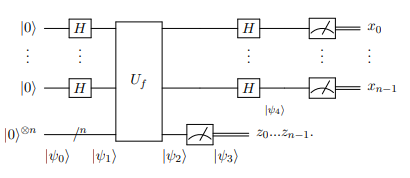

In [22]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from sympy import Matrix

%matplotlib inline


def solve_mod2_kernel(measurements):
    """
    Solve y · s = 0 (mod 2) for s given measurement outcomes y.
    """
    M = Matrix(measurements)
    M = M.applyfunc(lambda x: x % 2)

    nullsp = M.nullspace()
    if len(nullsp) == 0:
        return "0" * M.shape[1]

    s = nullsp[0]
    s = [int(x) % 2 for x in s]
    return "".join(map(str, s))

def simons_oracle(secret_s: str) -> QuantumCircuit:

    flag_bit = secret_s.find("1")

    n = len(secret_s)

    circ = QuantumCircuit(2 * n)

    for i in range(n):
        circ.cx(i, i + n)

    if flag_bit != -1:
        for index, bit_value in enumerate(secret_s):
            if bit_value not in ["0", "1"]:
                raise Exception("Incorrect char '" + bit_value + "' in secret string s:" + secret_s)
            if bit_value == "1":
                circ.cx(flag_bit, index + n)
    return circ


Secret string: 101

Collected equations:
[0, 1, 0]
[1, 1, 1]
[1, 0, 1]

Recovered string: 101


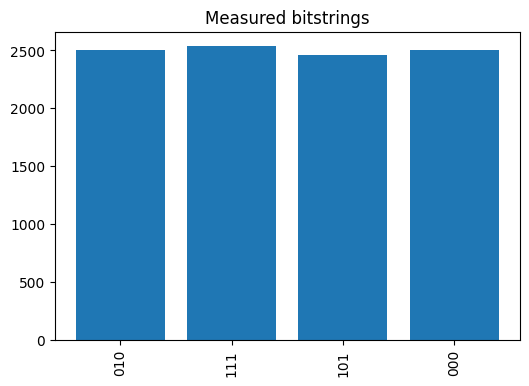

In [23]:

s = "101"
n = len(s)

print("Secret string:", s)

circ = QuantumCircuit(2 * n, n)

circ.h(range(n))

circ.compose(simons_oracle(s), inplace=True)

circ.h(range(n))

circ.measure(range(n), range(n))

simulator = AerSimulator()
shots = 10000
task = simulator.run(circ, shots=shots)
result = task.result()
counts = result.get_counts()

string_list = []
for bitstring in counts:
    if bitstring != "0" * n:
        string_list.append([int(c) for c in bitstring])

print("\nCollected equations:")
for row in string_list:
    print(row)

M = Matrix(string_list)
M = M.applyfunc(lambda x: x % 2)
M = M.rref()[0]
string_list = [list(map(int, row)) for row in M.tolist() if any(row)]

result_s = solve_mod2_kernel(string_list)

print("\nRecovered string:", result_s)

plt.figure(figsize=(6,4))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.title("Measured bitstrings")
plt.show()

## Źródła
- https://quantum.cloud.ibm.com/learning/en/courses/fundamentals-of-quantum-algorithms/
- https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/
- https://arxiv.org/abs/2201.10574
- https://arxiv.org/abs/quant-ph/9605043
- https://quantum.cloud.ibm.com/docs/en/tutorials/
- https://en.wikipedia.org/wiki/Shor%27s_algorithm
